In [1]:
# import libraries
import shutil
import os
import re
import cv2
from PIL import Image
import time
import numpy as np
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import glob
from keras.preprocessing import image
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize, LabelEncoder
from keras.utils import to_categorical
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io as io
%matplotlib inline

from keras import backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import np_utils


C:\Users\Loren\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Organizing and Prepare the Data

### Create train, validation, and test groups

In [3]:
# Read in file that dictates train, val, and test split
with open('list_eval_partition.txt', 'r') as eval_partition_file:
    # removing '\n' and first two line of the text as they contain colunms name
    list_eval_partition = [line.rstrip('\n') for line in eval_partition_file][2:]

In [4]:
list_eval_partition[: 5]

['img/Sheer_Pleated-Front_Blouse/img_00000001.jpg                        train',
 'img/Sheer_Pleated-Front_Blouse/img_00000002.jpg                        train',
 'img/Sheer_Pleated-Front_Blouse/img_00000003.jpg                        val',
 'img/Sheer_Pleated-Front_Blouse/img_00000004.jpg                        train',
 'img/Sheer_Pleated-Front_Blouse/img_00000005.jpg                        test']

In [5]:
# remove sapce and make two seperate strings "path of image" and 'label(train, test, val)'
list_eval_partition = [line.split() for line in list_eval_partition]
list_eval_partition[: 10]

[['img/Sheer_Pleated-Front_Blouse/img_00000001.jpg', 'train'],
 ['img/Sheer_Pleated-Front_Blouse/img_00000002.jpg', 'train'],
 ['img/Sheer_Pleated-Front_Blouse/img_00000003.jpg', 'val'],
 ['img/Sheer_Pleated-Front_Blouse/img_00000004.jpg', 'train'],
 ['img/Sheer_Pleated-Front_Blouse/img_00000005.jpg', 'test'],
 ['img/Sheer_Pleated-Front_Blouse/img_00000006.jpg', 'val'],
 ['img/Sheer_Pleated-Front_Blouse/img_00000007.jpg', 'test'],
 ['img/Sheer_Pleated-Front_Blouse/img_00000008.jpg', 'train'],
 ['img/Sheer_Pleated-Front_Blouse/img_00000009.jpg', 'train'],
 ['img/Sheer_Pleated-Front_Blouse/img_00000010.jpg', 'train']]

In [20]:
# get Categories or label from the name of the image
list_img_labels_prtitn =[(lst[0], lst[0].split('/')[1].split('_')[-1], lst[1]) 
                         for lst in list_eval_partition]



list_img_labels_prtitn[:10]

[('img/Sheer_Pleated-Front_Blouse/img_00000001.jpg', 'Blouse', 'train'),
 ('img/Sheer_Pleated-Front_Blouse/img_00000002.jpg', 'Blouse', 'train'),
 ('img/Sheer_Pleated-Front_Blouse/img_00000003.jpg', 'Blouse', 'val'),
 ('img/Sheer_Pleated-Front_Blouse/img_00000004.jpg', 'Blouse', 'train'),
 ('img/Sheer_Pleated-Front_Blouse/img_00000005.jpg', 'Blouse', 'test'),
 ('img/Sheer_Pleated-Front_Blouse/img_00000006.jpg', 'Blouse', 'val'),
 ('img/Sheer_Pleated-Front_Blouse/img_00000007.jpg', 'Blouse', 'test'),
 ('img/Sheer_Pleated-Front_Blouse/img_00000008.jpg', 'Blouse', 'train'),
 ('img/Sheer_Pleated-Front_Blouse/img_00000009.jpg', 'Blouse', 'train'),
 ('img/Sheer_Pleated-Front_Blouse/img_00000010.jpg', 'Blouse', 'train')]

In [28]:
# put each image into relevent folders---> train, test, val

for element in list_img_labels_prtitn:
    # create train, val , test folder element[2]
    if not os.path.exists(element[2]):
        os.mkdir(element[2])
    
    
    # create label folders inside train, test, val folders (element[2])
    if not os.path.exists(os.path.join(element[2], element[1])):
        os.mkdir(os.path.join(element[2], element[1]))
    
    
    # make corresponding images folders which are in original img folder inside 
    # label folders of each train, test, val folder.
    inside_folder_name = element[0].split('/')[1]  # eg: Sheer_Pleated-Front_Blouse
    
    
    if not os.path.exists(os.path.join(os.path.join(element[2], element[1]), inside_folder_name)):
                          
        os.mkdir(os.path.join(os.path.join(element[2], element[1]), inside_folder_name))
        
    
    
    # copying data from original image folder into train, test, val folders
    shutil.copy(element[0], os.path.join(os.path.join(element[2], element[1]), inside_folder_name))
    

In [119]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [3]:
#define paths for images
train_path = r"..\unit_7\train"
val_path = r"..\unit_7\val"
test_path = r"..\unit_7\test"

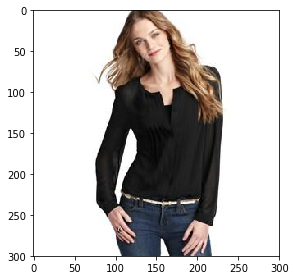

In [109]:
pleated_blouse = io.imread('train/blouse/Sheer_Pleated-Front_Blouse/img_00000001.jpg')

io.imshow(pleated_blouse)
io.show()

In [4]:
batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), batch_size=10)

Found 39713 images belonging to 30 classes.


In [145]:
imgs, labels = next(batches)

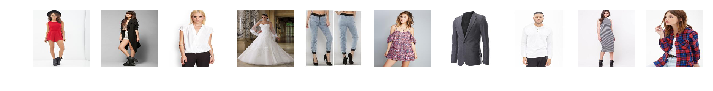

In [146]:
plots(imgs)

In [72]:
glob.glob('train' + '/*')[0].split('\\')[-1]

'Anorak'

In [138]:
# define function to get list of labels from folder names
def get_labels(folder_name):

    label_list = []
    for labels in glob.glob(folder_name + '/*'):
        label = labels.split('\\')[-1]
        for folder in glob.glob(labels + '/*'):
            for img_path in glob.glob(folder + '/*'):
                    
                label_list.append((label))
                    
    return label_list

In [139]:
#create list of labels 
train_labels = get_labels('train')
val_labels = get_labels('val')
test_labels = get_labels('test')

In [140]:
# create dict of training labels
labels_dict = {}
for i in train_labels:
    if i in labels_dict:
        labels_dict[i] += 1
    else:
        labels_dict[i] = 1


        
labels_dict

{'Blazer': 5408,
 'Blouse': 17752,
 'Cardigan': 9606,
 'Chinos': 374,
 'Coat': 1539,
 'Culottes': 359,
 'Cutoffs': 1177,
 'Dress': 52132,
 'Flannel': 224,
 'Henley': 521,
 'Hoodie': 2910,
 'Jacket': 7548,
 'Jeans': 5126,
 'Jeggings': 443,
 'Jersey': 534,
 'Joggers': 3260,
 'Jumpsuit': 4464,
 'Kimono': 1637,
 'Leggings': 3571,
 'Parka': 491,
 'Poncho': 579,
 'Romper': 5425,
 'Shorts': 14195,
 'Skirt': 10794,
 'Sweater': 9517,
 'Sweatpants': 2224,
 'Sweatshorts': 781,
 'Tank': 11204,
 'Tee': 26653,
 'Top': 7270}

In [156]:
batch_size = 10



#Image data generator, only rescaling
train_datagen = ImageDataGenerator(rescale=1./255)




#reads images from labeled directory
train_generator = train_datagen.flow_from_directory(
        train_path,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')




#Image data generator, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)




#reads images from labeled directory
validation_generator = test_datagen.flow_from_directory(
        val_path,
        target_size=(150, 150),
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')

Found 207718 images belonging to 30 classes.
Found 39720 images belonging to 30 classes.


In [162]:
num_classes = len(train_generator.class_indices)
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes) 

In [89]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(46))
model.add(Activation('softmax'))

model.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
__________

In [91]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

In [96]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,#train set / batch size
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)#train set / batch size
model.save_weights('first_model.h5') 

Epoch 1/50
62/62 [==============================] - ETA: 2:53 - loss: 4.1985 - acc: 0.0000e+0 - ETA: 2:12 - loss: 6.0401 - acc: 0.0156    - ETA: 1:56 - loss: 5.4653 - acc: 0.052 - ETA: 1:45 - loss: 5.1054 - acc: 0.078 - ETA: 1:37 - loss: 4.8442 - acc: 0.068 - ETA: 1:32 - loss: 4.6325 - acc: 0.083 - ETA: 1:28 - loss: 4.4954 - acc: 0.080 - ETA: 1:24 - loss: 4.3827 - acc: 0.078 - ETA: 1:21 - loss: 4.2987 - acc: 0.079 - ETA: 1:19 - loss: 4.2335 - acc: 0.081 - ETA: 1:17 - loss: 4.1780 - acc: 0.082 - ETA: 1:15 - loss: 4.1281 - acc: 0.088 - ETA: 1:12 - loss: 4.0818 - acc: 0.086 - ETA: 1:10 - loss: 4.0560 - acc: 0.087 - ETA: 1:08 - loss: 4.0269 - acc: 0.085 - ETA: 1:06 - loss: 4.0074 - acc: 0.085 - ETA: 1:04 - loss: 3.9899 - acc: 0.091 - ETA: 1:03 - loss: 3.9575 - acc: 0.097 - ETA: 1:01 - loss: 3.9178 - acc: 0.102 - ETA: 1:00 - loss: 3.8934 - acc: 0.107 - ETA: 58s - loss: 3.8703 - acc: 0.107 - ETA: 57s - loss: 3.8564 - acc: 0.10 - ETA: 55s - loss: 3.8379 - acc: 0.10 - ETA: 54s - loss: 3.8062 -

62/62 [==============================] - ETA: 1:35 - loss: 3.0274 - acc: 0.218 - ETA: 1:28 - loss: 2.8644 - acc: 0.281 - ETA: 1:23 - loss: 2.8860 - acc: 0.250 - ETA: 1:21 - loss: 2.9204 - acc: 0.257 - ETA: 1:21 - loss: 2.8628 - acc: 0.281 - ETA: 1:20 - loss: 2.9483 - acc: 0.255 - ETA: 1:18 - loss: 2.9336 - acc: 0.254 - ETA: 1:15 - loss: 2.9171 - acc: 0.253 - ETA: 1:13 - loss: 2.9333 - acc: 0.250 - ETA: 1:11 - loss: 2.9226 - acc: 0.253 - ETA: 1:10 - loss: 2.9199 - acc: 0.252 - ETA: 1:08 - loss: 2.9162 - acc: 0.250 - ETA: 1:06 - loss: 2.9072 - acc: 0.252 - ETA: 1:05 - loss: 2.9121 - acc: 0.247 - ETA: 1:03 - loss: 2.9118 - acc: 0.247 - ETA: 1:02 - loss: 2.9229 - acc: 0.242 - ETA: 1:00 - loss: 2.9128 - acc: 0.240 - ETA: 59s - loss: 2.9118 - acc: 0.241 - ETA: 58s - loss: 2.9045 - acc: 0.24 - ETA: 56s - loss: 2.8892 - acc: 0.24 - ETA: 55s - loss: 2.8837 - acc: 0.24 - ETA: 53s - loss: 2.8773 - acc: 0.24 - ETA: 52s - loss: 2.8685 - acc: 0.24 - ETA: 51s - loss: 2.8612 - acc: 0.24 - ETA: 49s - l

62/62 [==============================] - ETA: 1:36 - loss: 2.7177 - acc: 0.250 - ETA: 1:35 - loss: 2.7818 - acc: 0.281 - ETA: 1:32 - loss: 2.7161 - acc: 0.291 - ETA: 1:28 - loss: 2.6914 - acc: 0.304 - ETA: 1:25 - loss: 2.7006 - acc: 0.293 - ETA: 1:23 - loss: 2.7248 - acc: 0.265 - ETA: 1:20 - loss: 2.6590 - acc: 0.294 - ETA: 1:18 - loss: 2.6931 - acc: 0.281 - ETA: 1:16 - loss: 2.6807 - acc: 0.277 - ETA: 1:14 - loss: 2.6770 - acc: 0.284 - ETA: 1:13 - loss: 2.6773 - acc: 0.301 - ETA: 1:11 - loss: 2.7235 - acc: 0.294 - ETA: 1:10 - loss: 2.7290 - acc: 0.290 - ETA: 1:09 - loss: 2.7206 - acc: 0.281 - ETA: 1:07 - loss: 2.7220 - acc: 0.283 - ETA: 1:06 - loss: 2.7326 - acc: 0.275 - ETA: 1:04 - loss: 2.7146 - acc: 0.281 - ETA: 1:02 - loss: 2.7191 - acc: 0.279 - ETA: 1:01 - loss: 2.7263 - acc: 0.278 - ETA: 59s - loss: 2.7414 - acc: 0.271 - ETA: 58s - loss: 2.7333 - acc: 0.27 - ETA: 56s - loss: 2.7245 - acc: 0.26 - ETA: 55s - loss: 2.7487 - acc: 0.26 - ETA: 53s - loss: 2.7488 - acc: 0.26 - ETA: 52s

62/62 [==============================] - ETA: 1:35 - loss: 2.3821 - acc: 0.375 - ETA: 1:30 - loss: 2.6986 - acc: 0.281 - ETA: 1:24 - loss: 2.7824 - acc: 0.260 - ETA: 1:21 - loss: 2.7566 - acc: 0.242 - ETA: 1:19 - loss: 2.7804 - acc: 0.231 - ETA: 1:17 - loss: 2.7426 - acc: 0.260 - ETA: 1:15 - loss: 2.7259 - acc: 0.258 - ETA: 1:13 - loss: 2.7327 - acc: 0.242 - ETA: 1:12 - loss: 2.7393 - acc: 0.243 - ETA: 1:11 - loss: 2.7303 - acc: 0.246 - ETA: 1:10 - loss: 2.7430 - acc: 0.247 - ETA: 1:08 - loss: 2.7542 - acc: 0.247 - ETA: 1:06 - loss: 2.7305 - acc: 0.257 - ETA: 1:05 - loss: 2.7162 - acc: 0.258 - ETA: 1:03 - loss: 2.7237 - acc: 0.254 - ETA: 1:02 - loss: 2.7278 - acc: 0.257 - ETA: 1:00 - loss: 2.7096 - acc: 0.264 - ETA: 59s - loss: 2.7025 - acc: 0.265 - ETA: 58s - loss: 2.6807 - acc: 0.26 - ETA: 56s - loss: 2.6753 - acc: 0.26 - ETA: 55s - loss: 2.6891 - acc: 0.26 - ETA: 54s - loss: 2.6851 - acc: 0.26 - ETA: 53s - loss: 2.6777 - acc: 0.27 - ETA: 51s - loss: 2.6634 - acc: 0.27 - ETA: 50s - l

62/62 [==============================] - ETA: 1:43 - loss: 2.6850 - acc: 0.250 - ETA: 1:35 - loss: 2.5271 - acc: 0.296 - ETA: 1:28 - loss: 2.6245 - acc: 0.270 - ETA: 1:24 - loss: 2.6357 - acc: 0.257 - ETA: 1:21 - loss: 2.6979 - acc: 0.268 - ETA: 1:20 - loss: 2.6872 - acc: 0.291 - ETA: 1:19 - loss: 2.6593 - acc: 0.290 - ETA: 1:17 - loss: 2.6562 - acc: 0.296 - ETA: 1:15 - loss: 2.6914 - acc: 0.295 - ETA: 1:13 - loss: 2.6713 - acc: 0.293 - ETA: 1:11 - loss: 2.6534 - acc: 0.295 - ETA: 1:09 - loss: 2.6363 - acc: 0.309 - ETA: 1:08 - loss: 2.6492 - acc: 0.305 - ETA: 1:06 - loss: 2.6186 - acc: 0.308 - ETA: 1:04 - loss: 2.5782 - acc: 0.320 - ETA: 1:03 - loss: 2.6605 - acc: 0.306 - ETA: 1:01 - loss: 2.6696 - acc: 0.301 - ETA: 1:00 - loss: 2.6708 - acc: 0.307 - ETA: 59s - loss: 2.6815 - acc: 0.297 - ETA: 57s - loss: 2.6776 - acc: 0.29 - ETA: 56s - loss: 2.6824 - acc: 0.29 - ETA: 54s - loss: 2.6720 - acc: 0.29 - ETA: 53s - loss: 2.6600 - acc: 0.30 - ETA: 52s - loss: 2.6811 - acc: 0.29 - ETA: 50s -

62/62 [==============================] - ETA: 1:53 - loss: 2.4011 - acc: 0.406 - ETA: 1:44 - loss: 2.3760 - acc: 0.328 - ETA: 1:34 - loss: 2.4110 - acc: 0.333 - ETA: 1:28 - loss: 2.3884 - acc: 0.335 - ETA: 1:24 - loss: 2.4297 - acc: 0.337 - ETA: 1:21 - loss: 2.4661 - acc: 0.312 - ETA: 1:18 - loss: 2.4605 - acc: 0.317 - ETA: 1:16 - loss: 2.5419 - acc: 0.300 - ETA: 1:16 - loss: 2.5456 - acc: 0.291 - ETA: 1:15 - loss: 2.5460 - acc: 0.290 - ETA: 1:14 - loss: 2.5553 - acc: 0.289 - ETA: 1:12 - loss: 2.5401 - acc: 0.286 - ETA: 1:11 - loss: 2.5566 - acc: 0.278 - ETA: 1:10 - loss: 2.5571 - acc: 0.283 - ETA: 1:08 - loss: 2.5563 - acc: 0.291 - ETA: 1:06 - loss: 2.5820 - acc: 0.289 - ETA: 1:05 - loss: 2.5773 - acc: 0.288 - ETA: 1:03 - loss: 2.5930 - acc: 0.288 - ETA: 1:02 - loss: 2.6317 - acc: 0.284 - ETA: 1:00 - loss: 2.6365 - acc: 0.284 - ETA: 59s - loss: 2.6417 - acc: 0.285 - ETA: 57s - loss: 2.6500 - acc: 0.28 - ETA: 55s - loss: 2.6607 - acc: 0.27 - ETA: 54s - loss: 2.6506 - acc: 0.27 - ETA: 5

61/62 [============================>.] - ETA: 1:46 - loss: 2.8331 - acc: 0.250 - ETA: 1:40 - loss: 2.5482 - acc: 0.328 - ETA: 1:35 - loss: 2.5318 - acc: 0.343 - ETA: 1:32 - loss: 2.4788 - acc: 0.367 - ETA: 1:28 - loss: 2.4643 - acc: 0.337 - ETA: 1:27 - loss: 2.5068 - acc: 0.317 - ETA: 1:26 - loss: 2.5983 - acc: 0.299 - ETA: 1:24 - loss: 2.6064 - acc: 0.296 - ETA: 1:22 - loss: 2.5707 - acc: 0.302 - ETA: 1:20 - loss: 2.5801 - acc: 0.303 - ETA: 1:18 - loss: 2.5461 - acc: 0.306 - ETA: 1:16 - loss: 2.5460 - acc: 0.299 - ETA: 1:14 - loss: 2.5428 - acc: 0.295 - ETA: 1:12 - loss: 2.5370 - acc: 0.287 - ETA: 1:11 - loss: 2.5534 - acc: 0.281 - ETA: 1:09 - loss: 2.5404 - acc: 0.277 - ETA: 1:08 - loss: 2.5332 - acc: 0.279 - ETA: 1:06 - loss: 2.5391 - acc: 0.281 - ETA: 1:05 - loss: 2.5400 - acc: 0.279 - ETA: 1:03 - loss: 2.5324 - acc: 0.279 - ETA: 1:02 - loss: 2.5407 - acc: 0.279 - ETA: 1:00 - loss: 2.5403 - acc: 0.278 - ETA: 59s - loss: 2.5263 - acc: 0.281 - ETA: 57s - loss: 2.5111 - acc: 0.28 - ET

KeyboardInterrupt: 

In [8]:
pwd = os.getcwd()

In [9]:
train_path = r"..\unit_7\train"


In [14]:
data_path = r"..\unit_7\img"
img_category_path = pwd + '/Anno/list_category_img.txt'
category_name_path = pwd + '/Anno/list_category_cloth.txt'

In [147]:
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Using Bottleneck features from VGG16

In [164]:
from keras import applications

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = r"..\unit_7\train"
validation_data_dir = r"..\unit_7\val"
nb_train_samples = 207718
nb_validation_samples = 39720
epochs = 50
batch_size = 32

    
datagen = ImageDataGenerator(rescale=1. / 255)

# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)
bottleneck_features_train = model.predict_generator(
    generator, nb_train_samples // batch_size)
np.save(open('bottleneck_features_train.npy', 'w'),
        bottleneck_features_train)

num_classes = len(generator.class_indices)
train_labels = generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes) 

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)
bottleneck_features_validation = model.predict_generator(
    generator, nb_validation_samples // batch_size)
np.save(open('bottleneck_features_validation.npy', 'w'),
        bottleneck_features_validation)

num_classes = len(generator.class_indices)
validation_labels = generator.classes
validation_labels = to_categorical(train_labels, num_classes=num_classes)


Found 207718 images belonging to 30 classes.


KeyboardInterrupt: 

In [ ]:
def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy'))
    #train_labels = np.array(
        #[0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))

    validation_data = np.load(open('bottleneck_features_validation.npy'))
    #validation_labels = np.array(
        #[0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)


save_bottlebeck_features()
train_top_model()

In [ ]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense

# path to the model weights files.
weights_path = 'vgg16_weights.h5'
top_model_weights_path = 'bottleneck_fc_model.h5'
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = r"..\unit_7\train"
validation_data_dir = r"..\unit_7\val"
nb_train_samples = 207718
nb_validation_samples = 39720
epochs = 50
batch_size = 32

# build the VGG16 network
model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
#model = applications.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
input_tensor = Input(shape=(150,150,3))
base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
#top_model = Sequential()
#top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
#top_model.add(Dense(256, activation='relu'))
#top_model.add(Dropout(0.5))
#top_model.add(Dense(1, activation='sigmoid'))
#top_model.load_weights('bootlneck_fc_model.h5')
#model = Model(input= base_model.input, output= top_model(base_model.output))
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))



# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
#model.add(top_model)
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

model.sumary()

# fine-tune the model
#model.fit_generator(
#    train_generator,
#    samples_per_epoch=nb_train_samples,
#    epochs=epochs,
#    validation_data=validation_generator,
#    nb_val_samples=nb_validation_samples)

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size, verbose=2)